In [1]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [2]:
import pandas as pd
import gc
import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm
import copy
from torch.utils.data import Dataset, DataLoader
import torch

from torch.nn import Conv2d, Linear, ReLU, Dropout
from torch.nn import Module
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import KFold

from torch.optim import Adam
from sklearn.metrics import accuracy_score

# Dataset

In [3]:
DEBUG = True

data = pd.read_csv('Othello_Kihu.txt', header=None, sep=' ')

if DEBUG:
    data = data.sample(n=10000)
data = data[data[64]!=0] #石を置けない場合(0, 0)のactionをとるが、データ数が１だけなので除外する
data.iloc[:, :64] = data.iloc[:, :64].where( data.iloc[:, :64] != 2, -1) # 黒 : -1, 白 : 1, 何もなし : 0　の 8*8 の盤面を持つ　ようにする
cols = [ i for i in range(64)]
data.loc[data[66]=='B', cols] = data.loc[data[66]=='B', cols]*-1 # 黒手番の場合、自分と相手を入れ替える　モデルが理解しやすいように

gc.collect()

print(data.shape)
data.head()

(10000, 68)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67
5745333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,-1,0,0,0,0,-1,-1,-1,-1,-1,0,0,0,1,-1,-1,-1,1,0,0,0,0,0,-1,-1,1,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,5,7,W,47
3262322,0,0,0,-1,-1,-1,0,0,0,0,-1,-1,1,1,0,0,0,1,-1,-1,1,1,0,0,0,-1,-1,-1,1,1,1,0,0,-1,-1,-1,1,1,1,0,0,0,-1,-1,-1,-1,-1,0,0,0,1,1,1,-1,0,0,0,0,0,0,0,0,0,0,6,8,W,31
2747377,0,0,0,0,0,0,0,0,0,0,1,-1,0,1,0,0,0,-1,-1,1,-1,-1,-1,0,0,-1,-1,-1,-1,-1,-1,0,0,1,1,-1,-1,1,-1,0,0,0,1,1,-1,1,0,-1,0,0,1,1,1,1,0,0,0,0,1,-1,-1,1,0,0,8,5,B,30
1501570,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,1,-1,0,0,0,0,-1,-1,-1,-1,-1,0,0,0,0,-1,-1,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,6,3,B,48
5573901,0,0,0,-1,-1,-1,-1,0,0,0,0,-1,1,1,0,0,0,0,-1,1,1,1,1,1,0,0,1,-1,1,1,1,1,0,0,1,1,1,1,-1,1,0,0,1,1,1,1,1,1,0,0,0,1,1,-1,0,1,0,0,-1,-1,-1,0,0,0,2,3,B,26


In [4]:
# 盤面を渡すと、今回置ける場所を返してくれる
# 0が置いてない場所、1が自分の意思がある場所、-1が相手の石が置いてある場所

def check(board): #今回の手番の人が打てる場所をリストアップする
    okeru_list = []
    for x in range(8):
        for y in range(8):
            plc = board[y, x]
            if plc == 0: #もし今回のplaceに何も置いていなければ8方向探索する
                able = octpass([x,y], board) #今回の場所に置いたときひっくり返せる場所をリストアップする
                if len(able) > 0: #もしひっくり返せる場所が0ではないなら置ける場所リストに今回の場所を追加する
                    okeru_list.append([y,x])
    return okeru_list
  
def octpass(basho, board): #今回置きたい場所を渡したら８方向探索するメソッド
    basho_list = set() #今回ひっくり返せる場所のリスト(setクラスを使う→重複なしで扱える)

    if board[basho[1], basho[0]] != 0:
        print('既に石が置かれています')
    else:
        for x in [-1,0,1]:
            for y in [-1,0,1]: #8方向を順に見ていく
                tmp = [] #今回の確認する方向でひっくり返そうな場所を一時的に記憶しておくリスト

                if x == 0 and y == 0:
                    pass #方向がないときはパスする

                for length in range(1,9): #今回確認する方向にだんだん腕を伸ばしていく
                    if 0<=basho[1]+y*length<=7 and 0<=basho[0]+x*length<=7: #腕が盤面に収まるのなら
                        check_plc = board[basho[1]+y*length, basho[0]+x*length]
                        if check_plc == 0: #もし確認した場所に何も置いていなければ、飛び石になっちゃうので手を伸ばすのを終了
                            break
                        elif check_plc == -1: #もし確認した場所が相手プレイヤーの石だった場合その場所を一時記憶しておく
                            tmp.append( (basho[0]+x*length, basho[1]+y*length) )
                        elif check_plc == 1: #もし確認した場所が自分の石だった場合、ひっくり返せるリストに現在ひっくり返せそうな場所を追加して腕を伸ばすのをやめる
                            if len(tmp) > 0: #中身がからでない場合のみ
                                basho_list |= set(tmp)
                            break #手を伸ばすのを終了
    
                    else: #もし盤面を飛び出してしまうならpassする
                        pass
    return list(basho_list)

In [6]:
class OCDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.States = df.iloc[:, :64] #盤面
        self.player = df.iloc[:, 66] #W or B
        self.action = 8*(df.iloc[:, 65]-1) + (df.iloc[:, 64]-1) #0-63のどこに置くか

    def __len__(self):
        return self.States.shape[0]

    def __getitem__(self, idx):
        state_can = np.zeros((8,8))
        state = self.States.iloc[idx].values.reshape(8,8)
        puttables = check(state)
        for puttable_place in puttables:
            state_can[puttable_place[0], puttable_place[1]] = 1 # 現在の手番が石を置ける場所

        state_my = (state == 1).astype(np.uint8) #自分の石の位置
        state_op = (state == -1).astype(np.uint8) #相手の石の位置
        #state_on = (state != 0).astype(np.uint8)   # 盤面の石の位置
        states = np.stack( [state_can, state_my, state_op] )

        states = torch.tensor( states, dtype=torch.float32 )
        action = torch.tensor( self.action.iloc[idx], dtype=torch.int64 )

        return states, action, self.player.iloc[idx]

# Check Dataset

64    8
65    5
Name: 2402125, dtype: object
W
毎回白手番です
[[2, 0], [4, 0], [1, 1], [7, 3], [7, 4], [7, 5], [1, 6], [6, 6], [1, 7], [2, 7], [3, 7]]


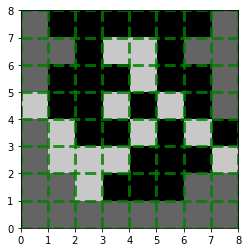

In [5]:
idx = 8

table = data.iloc[idx, :64].values.reshape(8,8)
actions = data.iloc[idx, [64, 65]]
color = data.iloc[idx, 66]

table = table[-1::-1, :]
table_orig = copy.deepcopy(table)

table = np.tile(table, 3 ).reshape(8, 3,8).transpose(0,2,1).astype(np.int16)

plt.close()
#plt.imshow((-3*table**2+7*table)*100+100, extent=(0,8,0,8), cmap='bwr')
plt.imshow((table)*100+100, extent=(0,8,0,8), cmap='bwr')
plt.xticks([0,1,2,3,4,5,6,7,8])
# x軸に補助目盛線を設定
plt.grid(which = "major", axis = "x", color = "green", alpha = 0.8,
        linestyle = "--", linewidth = 3)

# y軸に目盛線を設定
plt.grid(which = "major", axis = "y", color = "green", alpha = 0.8,
        linestyle = "--", linewidth = 3)

print(actions)
print(color)
print('毎回白手番です')
print(check(table_orig))

tensor(2)
y : tensor(1)
x : tensor(3)
B
常に緑の手番ということになってます
赤が今回緑の人が置ける場所


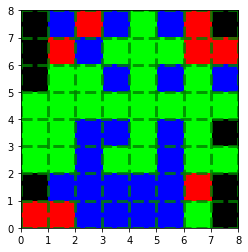

In [7]:
A = OCDataset(data)
B = DataLoader(
    dataset = A,
    batch_size=3,
    shuffle=True
)
states, action, color = iter(B).next()
#print(states[0])

plt.imshow( states[0].numpy().transpose(1,2,0) ,extent=(0,8,0,8), cmap='bwr')
plt.xticks([0,1,2,3,4,5,6,7,8])
# x軸に補助目盛線を設定
plt.grid(which = "major", axis = "x", color = "green", alpha = 0.8,
        linestyle = "--", linewidth = 3)

# y軸に目盛線を設定
plt.grid(which = "major", axis = "y", color = "green", alpha = 0.8,
        linestyle = "--", linewidth = 3)
print(action[0])
print( "y :",action[0]//8 +1 )
print( "x :",action[0]%8 +1 )
print(color[0]) 
print('常に緑の手番ということになってます')
print('赤が今回緑の人が置ける場所')

# Model

In [8]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.BN1   = nn.BatchNorm2d(num_features=64)
        self.act1   = nn.ReLU()
        self.drop1   = nn.Dropout(p=0.3)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.BN2   = nn.BatchNorm2d(num_features=128)
        self.act2   = nn.ReLU()
        self.drop2   = nn.Dropout(p=0.3)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.BN3   = nn.BatchNorm2d(num_features=256)
        self.act3   = nn.ReLU()
        self.drop3   = nn.Dropout(p=0.3)

        self.conv4 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.BN4   = nn.BatchNorm2d(num_features=128)
        self.act4   = nn.ReLU()
        self.drop4   = nn.Dropout(p=0.3)

        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(in_features=128, out_features=256)
        self.act_linear   = nn.ReLU()
        
        self.linear2 = nn.Linear(in_features=256, out_features=64)

    def forward(self, x):
        x = self.conv1(x)
        x = self.BN1(x)
        x = self.act1(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = self.BN2(x)
        x = self.act2(x)
        x = self.drop2(x)

        x = self.conv3(x)
        x = self.BN3(x)
        x = self.act3(x)
        x = self.drop3(x)

        x = self.conv4(x)
        x = self.BN4(x)
        x = self.act4(x)
        x = self.drop4(x)

        x = F.max_pool2d(x, kernel_size=x.size()[2:])
        x = x[:,:,0,0]

        x = self.linear1(x)
        x = self.act_linear(x)

        x = self.linear2(x)
        return x

# Training

In [9]:
BATCH_SIZE = 16

def get_folds(NUM_FOLDS=5):
    kfold = KFold(n_splits=NUM_FOLDS, shuffle=True)
    folds = np.ones(data.shape[0])

    for i, (trn_idx, val_idx) in enumerate(kfold.split(data)):
        folds[val_idx] = i
    return folds

def get_loaders(df, folds, n_fold):
    trn_df = df[(folds!=n_fold)]
    val_df = df[(folds==n_fold)]

    trn_dataset = OCDataset(trn_df)
    val_dataset = OCDataset(val_df)

    trn_loader = DataLoader(
        dataset = trn_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    val_loader = DataLoader(
        dataset = val_dataset,
        batch_size = BATCH_SIZE,
        shuffle=False
    )
    return trn_loader, val_loader

#folds = get_folds(NUM_FOLDS=5)
#trn_loader, val_loader = get_loaders(data, folds, 0)

In [ ]:
#trn_loader, val_loader = get_loaders(data, folds, 0)
#model = CNNModel()#.to(DEVICE)
#metrics = nn.CrossEntropyLoss()
#
#states, action, color  = iter(trn_loader).next()
#pred = model(states)
#metrics(pred, action)
#
##valid_fn(model, val_loader, metrics)

In [11]:
def train_fn(model, optim, trn_loader, metrics):
    train_loss = 0
    accs = []
    for table, action, _ in tqdm(trn_loader):
        model.train()
        optim.zero_grad()
        table   = table.to(DEVICE)
        action = action.to(DEVICE)
        pred = model(table)
        loss  = metrics(pred, action)
        loss.backward()
        optim.step()

        train_loss += loss.cpu().detach().numpy()
        acc  = accuracy_score(action.cpu().detach().numpy(), np.argmax(pred.cpu().detach().numpy(), axis=1  ))
        accs.append(acc)
    return train_loss / len(trn_loader), np.mean(accs)

def valid_fn(model, val_loader, metrics):
    valid_loss = 0
    accs = []
    for table, action, _ in  tqdm(val_loader):
        with torch.no_grad():
            model.eval()
            table = table.to(DEVICE)
            action = action.to(DEVICE)
            pred = model(table)
            loss  = metrics(pred, action)

            acc  = accuracy_score(action.cpu().detach().numpy(), np.argmax(pred.cpu().detach().numpy(), axis=1  ))
            valid_loss += loss.cpu().detach().numpy()
            accs.append(acc)
    return valid_loss/len(val_loader), np.mean(accs)

In [12]:
EPOCHS = 100
DEVICE = 'cuda:0'
metrics = nn.CrossEntropyLoss()

train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

trn_loader, val_loader = get_loaders(data, folds, 0)
model = CNNModel().to(DEVICE)
optim = Adam(params=model.parameters(), lr=0.0005)

for epoch in range(EPOCHS):  
    train_loss = 0
    train_loss, train_acc =train_fn(model, optim, trn_loader, metrics)
    valid_loss, valid_acc = valid_fn(model, val_loader, metrics)

    print('train_loss :', train_loss)
    print('train_acc :', train_acc)
    print('valid_loss :', valid_loss)
    print('valid_acc :', valid_acc)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)


train_loss : 3.7397726488113405
train_acc : 0.052875
valid_loss : 3.567475576400757
valid_acc : 0.071



train_loss : 3.446387150287628
train_acc : 0.091375
valid_loss : 3.3943819580078123
valid_acc : 0.091



train_loss : 3.2310431914329527
train_acc : 0.122125
valid_loss : 3.1789166107177733
valid_acc : 0.133



train_loss : 3.0203352332115174
train_acc : 0.16275
valid_loss : 2.9674372653961183
valid_acc : 0.1615



train_loss : 2.8449596536159514
train_acc : 0.1915
valid_loss : 2.8504583206176757
valid_acc : 0.1935



train_loss : 2.690255207777023
train_acc : 0.220875
valid_loss : 2.701972694396973
valid_acc : 0.2115



train_loss : 2.581777253866196
train_acc : 0.247
valid_loss : 2.6017233572006226
valid_acc : 0.2405



train_loss : 2.477569756746292
train_acc : 0.275875
valid_loss : 2.5253454246520994
valid_acc : 0.261



train_loss : 2.392352494239807
train_acc : 0.29475
valid_loss : 2.4269890069961546
valid_acc : 0.293



train_loss : 2.301670276880264
train_acc : 0.3195
valid_loss : 2.376811806678772
valid_acc : 0.321



train_loss : 2.2316993262767792
train_acc : 0.33825
valid_loss : 2.35455478477478
valid_acc : 0.3085



train_loss : 2.174091316461563
train_acc : 0.348875
valid_loss : 2.3037844047546385
valid_acc : 0.3095



train_loss : 2.1208152439594268
train_acc : 0.359625
valid_loss : 2.297102919578552
valid_acc : 0.318



train_loss : 2.0774582114219666
train_acc : 0.374625
valid_loss : 2.2248200340270996
valid_acc : 0.3365



train_loss : 2.0247421951293947
train_acc : 0.387375
valid_loss : 2.243900191307068
valid_acc : 0.338



train_loss : 1.9733485375642776
train_acc : 0.397875
valid_loss : 2.1808973121643067
valid_acc : 0.3625



train_loss : 1.9404063513278962
train_acc : 0.411625
valid_loss : 2.159018187522888
valid_acc : 0.3495



train_loss : 1.9111832699775695
train_acc : 0.415
valid_loss : 2.1505772762298583
valid_acc : 0.345



train_loss : 1.8566384079456328
train_acc : 0.429
valid_loss : 2.100097170829773
valid_acc : 0.36



train_loss : 1.8161472907066345
train_acc : 0.441875
valid_loss : 2.0923988208770754
valid_acc : 0.358



train_loss : 1.792432874917984
train_acc : 0.441
valid_loss : 2.1444944896697997
valid_acc : 0.3535



train_loss : 1.7673392556905747
train_acc : 0.449375
valid_loss : 2.1039133672714234
valid_acc : 0.3565



train_loss : 1.7341278269290925
train_acc : 0.4565
valid_loss : 2.0781989965438843
valid_acc : 0.3685



train_loss : 1.6861877439022064
train_acc : 0.47
valid_loss : 2.0737143659591677
valid_acc : 0.376



train_loss : 1.6684356517791747
train_acc : 0.47125
valid_loss : 2.068884690284729
valid_acc : 0.364



train_loss : 1.6413950344324113
train_acc : 0.479625
valid_loss : 2.0578527784347536
valid_acc : 0.3655



train_loss : 1.6119255713224412
train_acc : 0.488
valid_loss : 2.055005555152893
valid_acc : 0.3675



train_loss : 1.605331747174263
train_acc : 0.48625
valid_loss : 2.0506749763488767
valid_acc : 0.3765



train_loss : 1.5661377530097962
train_acc : 0.49725
valid_loss : 2.0294803104400634
valid_acc : 0.39



train_loss : 1.5455652383565903
train_acc : 0.515625
valid_loss : 2.0511266689300536
valid_acc : 0.377



train_loss : 1.512253521323204
train_acc : 0.518
valid_loss : 2.0502337589263915
valid_acc : 0.369



train_loss : 1.522177879691124
train_acc : 0.5045
valid_loss : 2.0394721202850343
valid_acc : 0.3845



train_loss : 1.494377730488777
train_acc : 0.528875
valid_loss : 2.058355185508728
valid_acc : 0.385



train_loss : 1.4534238908290864
train_acc : 0.534875
valid_loss : 2.037287315368652
valid_acc : 0.381



train_loss : 1.4416762433052064
train_acc : 0.534125
valid_loss : 2.056483578681946
valid_acc : 0.3915



train_loss : 1.4451949599981309
train_acc : 0.53575
valid_loss : 2.0188692932128904
valid_acc : 0.3895



train_loss : 1.3831455892324447
train_acc : 0.54725
valid_loss : 2.0749477310180664
valid_acc : 0.371



train_loss : 1.377645548582077
train_acc : 0.54975
valid_loss : 2.0419265260696413
valid_acc : 0.395



train_loss : 1.359530305147171
train_acc : 0.557125
valid_loss : 2.0329817180633545
valid_acc : 0.3815



train_loss : 1.3411024115085601
train_acc : 0.5645
valid_loss : 2.0641344394683836
valid_acc : 0.3715



train_loss : 1.3539977431297303
train_acc : 0.557875
valid_loss : 2.0666122074127196
valid_acc : 0.3795



train_loss : 1.2999479041695594
train_acc : 0.5805
valid_loss : 2.0659976625442504
valid_acc : 0.3695



train_loss : 1.2787308573126792
train_acc : 0.581
valid_loss : 2.064199504852295
valid_acc : 0.388



train_loss : 1.2822599359750748
train_acc : 0.58225
valid_loss : 2.1019965925216675
valid_acc : 0.3765



train_loss : 1.2716535046100617
train_acc : 0.578875
valid_loss : 2.07405446434021
valid_acc : 0.3715



train_loss : 1.220154626786709
train_acc : 0.595875
valid_loss : 2.1451654996871947
valid_acc : 0.36



train_loss : 1.2351133462786674
train_acc : 0.5935
valid_loss : 2.1241535024642944
valid_acc : 0.376



train_loss : 1.2120311557650567
train_acc : 0.602625
valid_loss : 2.1297529411315916
valid_acc : 0.37



train_loss : 1.1885016970038413
train_acc : 0.6015
valid_loss : 2.091980799674988
valid_acc : 0.3685



train_loss : 1.206025833249092
train_acc : 0.602875
valid_loss : 2.154945231437683
valid_acc : 0.3765



train_loss : 1.16256053429842
train_acc : 0.621
valid_loss : 2.118632122039795
valid_acc : 0.376



train_loss : 1.17144923889637
train_acc : 0.611125
valid_loss : 2.0988662548065187
valid_acc : 0.38



train_loss : 1.1302916967272758
train_acc : 0.621375
valid_loss : 2.1016635513305664
valid_acc : 0.3845



train_loss : 1.1378086485266685
train_acc : 0.623625
valid_loss : 2.120289422035217
valid_acc : 0.3805



train_loss : 1.1063973416686057
train_acc : 0.638125
valid_loss : 2.1188960800170897
valid_acc : 0.381



train_loss : 1.1047775151729584
train_acc : 0.63025
valid_loss : 2.1154203405380247
valid_acc : 0.3775



train_loss : 1.0773638694286347
train_acc : 0.63875
valid_loss : 2.1399193716049196
valid_acc : 0.387



train_loss : 1.0943685048818588
train_acc : 0.631125
valid_loss : 2.115757378578186
valid_acc : 0.388



train_loss : 1.0557783374786376
train_acc : 0.65075
valid_loss : 2.1928346557617187
valid_acc : 0.3795



train_loss : 1.06407326066494
train_acc : 0.64775
valid_loss : 2.1525156469345093
valid_acc : 0.3795



train_loss : 1.061601655483246
train_acc : 0.645125
valid_loss : 2.1911548709869386
valid_acc : 0.3775



train_loss : 1.0191906891465188
train_acc : 0.66675
valid_loss : 2.1707671689987182
valid_acc : 0.376



train_loss : 1.0308875775337218
train_acc : 0.658
valid_loss : 2.1871529474258424
valid_acc : 0.387



train_loss : 0.9880826152563095
train_acc : 0.666125
valid_loss : 2.2175445985794067
valid_acc : 0.3755



train_loss : 0.9851399729251862
train_acc : 0.67075
valid_loss : 2.2374676876068116
valid_acc : 0.3825



train_loss : 0.9735998150110244
train_acc : 0.6715
valid_loss : 2.1730603914260866
valid_acc : 0.3755



train_loss : 0.9704248759746551
train_acc : 0.670875
valid_loss : 2.230061368942261
valid_acc : 0.373



train_loss : 0.9705266243219376
train_acc : 0.672875
valid_loss : 2.2332730693817138
valid_acc : 0.3735



train_loss : 0.9583882613182068
train_acc : 0.678875
valid_loss : 2.2080970149040224
valid_acc : 0.3655



train_loss : 0.9715392673015595
train_acc : 0.664
valid_loss : 2.199891062736511
valid_acc : 0.3755



train_loss : 0.9257806910276413
train_acc : 0.689
valid_loss : 2.2620853033065798
valid_acc : 0.378



train_loss : 0.919224615007639
train_acc : 0.688
valid_loss : 2.231774666786194
valid_acc : 0.3795



train_loss : 0.9349490944743156
train_acc : 0.68875
valid_loss : 2.2648990449905395
valid_acc : 0.3765



train_loss : 0.8988710299134255
train_acc : 0.69925
valid_loss : 2.29010214805603
valid_acc : 0.3695



train_loss : 0.9128394099771977
train_acc : 0.687375
valid_loss : 2.2759358739852904
valid_acc : 0.3685



train_loss : 0.9009320037961006
train_acc : 0.694
valid_loss : 2.2806531896591187
valid_acc : 0.364



train_loss : 0.8710831463038922
train_acc : 0.704375
valid_loss : 2.279859209060669
valid_acc : 0.3765



train_loss : 0.8828255845308304
train_acc : 0.70025
valid_loss : 2.306554639816284
valid_acc : 0.3405



train_loss : 0.8734446232616901
train_acc : 0.70625
valid_loss : 2.2981495447158813
valid_acc : 0.3625



train_loss : 0.8709723264575004
train_acc : 0.70625
valid_loss : 2.2646174092292783
valid_acc : 0.378



train_loss : 0.8761754856109619
train_acc : 0.697375
valid_loss : 2.3089667387008666
valid_acc : 0.3665



train_loss : 0.8420463620126247
train_acc : 0.713625
valid_loss : 2.250853549003601
valid_acc : 0.366



train_loss : 0.8399485456943512
train_acc : 0.710625
valid_loss : 2.2788598575592043
valid_acc : 0.377



train_loss : 0.8309436174333096
train_acc : 0.722625
valid_loss : 2.301599708557129
valid_acc : 0.376



train_loss : 0.820670385926962
train_acc : 0.7215
valid_loss : 2.330820044517517
valid_acc : 0.3675



train_loss : 0.8296784424483776
train_acc : 0.718125
valid_loss : 2.3344995946884155
valid_acc : 0.3655



train_loss : 0.8110231614112854
train_acc : 0.716875
valid_loss : 2.2907545461654664
valid_acc : 0.372



train_loss : 0.8037356924414635
train_acc : 0.727
valid_loss : 2.3249831838607786
valid_acc : 0.3875



train_loss : 0.8086047213971614
train_acc : 0.724125
valid_loss : 2.319521636962891
valid_acc : 0.3655



train_loss : 0.784225154966116
train_acc : 0.732
valid_loss : 2.328304160118103
valid_acc : 0.3765



train_loss : 0.8076251391172409
train_acc : 0.72275
valid_loss : 2.347965343475342
valid_acc : 0.3745



train_loss : 0.7919719029068947
train_acc : 0.730875
valid_loss : 2.3280251083374024
valid_acc : 0.366



train_loss : 0.765212638258934
train_acc : 0.735625
valid_loss : 2.324105076789856
valid_acc : 0.375



train_loss : 0.7863057158887387
train_acc : 0.731375
valid_loss : 2.299814853668213
valid_acc : 0.3805



train_loss : 0.7616019083261489
train_acc : 0.73725
valid_loss : 2.3685512800216673
valid_acc : 0.371



train_loss : 0.781052805095911
train_acc : 0.729625
valid_loss : 2.360458384513855
valid_acc : 0.3635



train_loss : 0.7776650845706463
train_acc : 0.729375
valid_loss : 2.3466417169570923
valid_acc : 0.3665



train_loss : 0.7458372992277146
train_acc : 0.74225
valid_loss : 2.341976312637329
valid_acc : 0.3745



train_loss : 0.7585673938989639
train_acc : 0.7375
valid_loss : 2.3225656909942627
valid_acc : 0.3735



train_loss : 0.7357111330032349
train_acc : 0.747375
valid_loss : 2.4357214193344117
valid_acc : 0.366


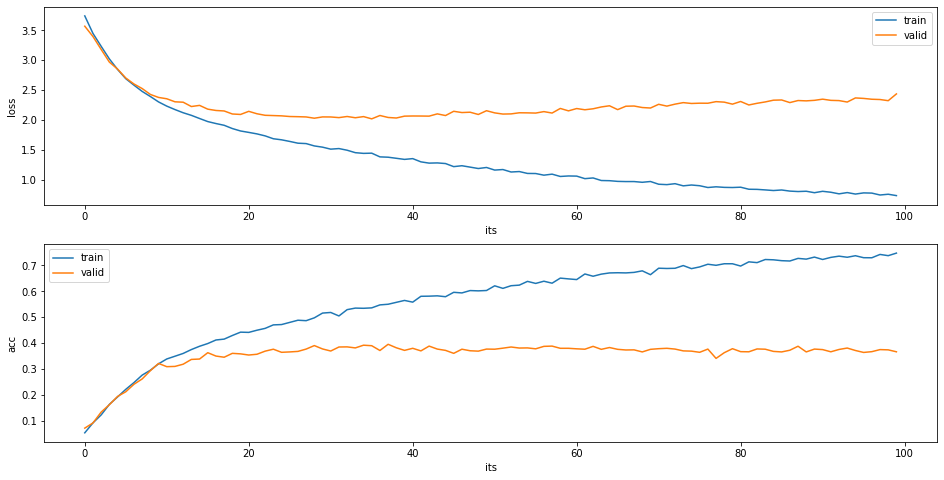

In [13]:
train_loss_hist = pd.DataFrame(train_losses)
train_acc_hist = pd.DataFrame(train_accs)
val_loss_hist = pd.DataFrame(valid_losses)
val_acc_hist = pd.DataFrame(valid_accs)
fig, axes = plt.subplots(2, 1, figsize = (16, 8))
axes[0].plot(train_loss_hist, label = "train")
axes[0].plot(val_loss_hist, label = "valid")
axes[0].legend(loc = "best")
axes[0].set_xlabel("its")
axes[0].set_ylabel("loss")
axes[1].plot(train_acc_hist, label = "train")
axes[1].plot(val_acc_hist, label = "valid")
axes[1].legend(loc = "best")
axes[1].set_xlabel("its")
axes[1].set_ylabel("acc")
plt.show()